In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_3919/2647508162.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from cardiac import templates
from cardiac import fields
from cardiac import spectrum

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generating templates of anisotropic shifts in $dN/dz$

We can generate a mock template providing the following inputs:
- `sigma_of_shift` = float. Standard deviation of the shifts across the template
- `nside` = int. Defines the pixelization
- `alpha` = float. Power law index for the perturbation Cls
- `lmax_pert` = int. lmax of the Cls

In [3]:
sigma_of_shift = 0.003
nside = 128
alpha = -2
lmax_pert = 100

# Make a mask
ipix_disc = hp.query_disc(nside=nside, vec=hp.ang2vec(np.pi/2, 0), radius=np.radians(30))
mask = np.zeros(hp.nside2npix(nside))
mask[ipix_disc] = 1

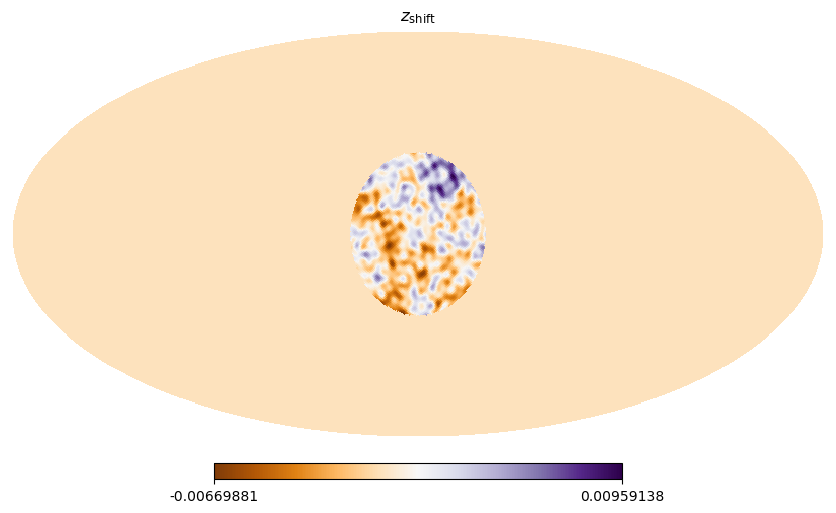

In [5]:
test_mock_template = templates.MockTemplate(sigma_of_shift, nside, alpha, lmax_pert, mask=mask)
test_mock_template.show()

Alternatively, if we already have a template characterizing the shifts in either the mean redshift or width of our $dN/dz$ in every pixel of some healpix pixelization, we can use the CustomTemplate class as follows:

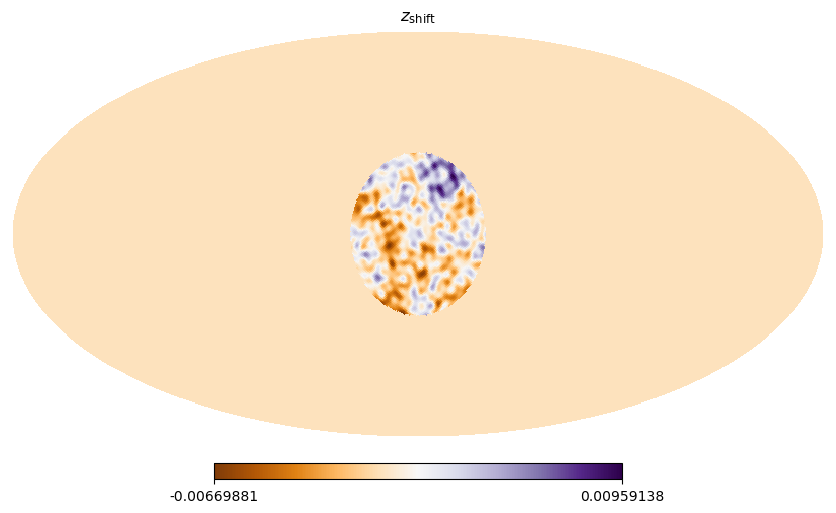

In [6]:
myshifts_template = test_mock_template.map

test_custom_template = templates.CustomTemplate(myshifts_template, mask=mask)
test_custom_template.show()

# Constructing `field` objects

We first need to introduce a `grid` object that will define the discrete redshifts we will be working with as well as the healpix pixelization (this will need to match our anisotropy templates)

In [13]:
n_samples_of_chi = 2**8 # (a power of 2). Number of samples in chi
sigma = 0.06 # Standard deviation of the fiducial dndz
z_mean = 0.59 # Central redshift of the fiducial dndz
z_max_int = z_mean + 10*sigma # Higher end of the integration range in redshift

my_grid = fields.grid(nside, n_samples_of_chi, z_max_int=z_max_int)

We'll now use one of the templates above to initialize objects corresponding to observed fields subject to projection anisotropy

In [14]:
#UNIT-redmagic bias parameters from 2101.11014
#         b1,    b2,    bs2,   bnabla2, SN
bvec = [0.786, 0.583, -0.406, -0.512, 1755]

gal_overdensity = fields.GalDelta(my_grid, sigma, z_mean, bvec, template_zmean_shifts=test_mock_template)

This `bvec` variable contains information about the galaxy bias in a format appropriate for the `Anzu` code. But note that the code can be easily modified to call the user's favorite power spectrum method.

In [15]:
gal_kappa = fields.GalShear(my_grid, sigma, z_mean, template_zmean_shifts=test_mock_template)

Notice that these inherit the properties of the `Template` around which it is constructed, for example:

In [16]:
gal_overdensity.template_zmean_shifts.__dict__

{'lmax_pert': 100,
 'alpha': -2,
 'map': array([0.00037333, 0.00031488, 0.00048739, ..., 0.00450596, 0.00535311,
        0.00515002]),
 'npix': 196608,
 'nside': 128,
 'sigma_of_shift': 0.003}

# Define a `Spec` object

Here are some examples of spectra we can compute

In [17]:
cs_auto = spectrum.Spec(gal_kappa) # A cosmic shear power spectrum
gc_auto = spectrum.Spec(gal_overdensity) # A galaxy clustering power spectrum
ggl = spectrum.Spec(gal_kappa, gal_overdensity) # Galaxy-galaxy lensing

These already have some interesting properties. For example, the covariance in each redshift slice will let us predict the biases on small angular scales

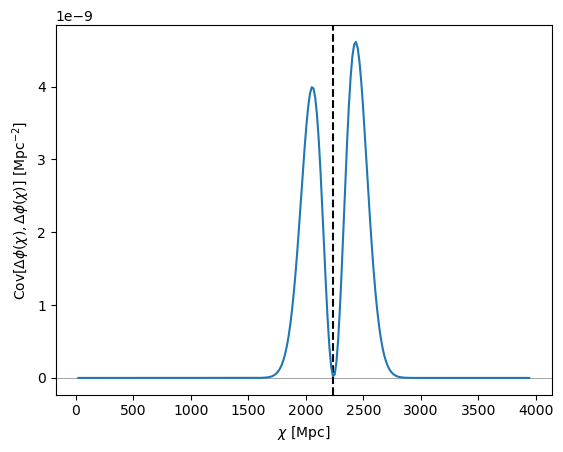

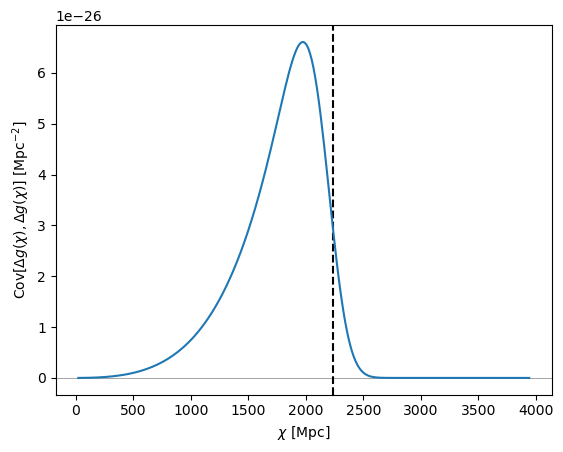

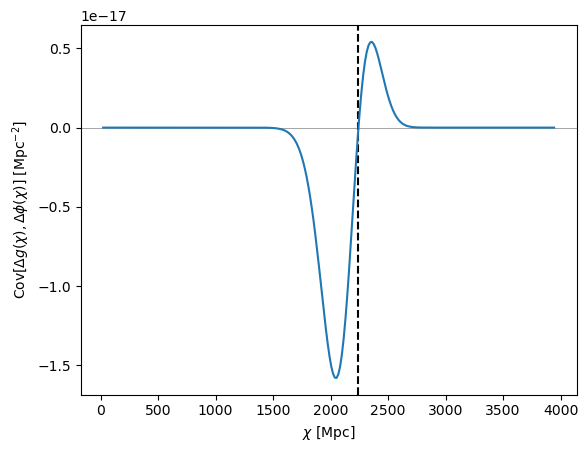

In [18]:
gc_auto.plot_DeltaP_covariance()
cs_auto.plot_DeltaP_covariance()
ggl.plot_DeltaP_covariance()

These objects also contain the fiducial projection kernels

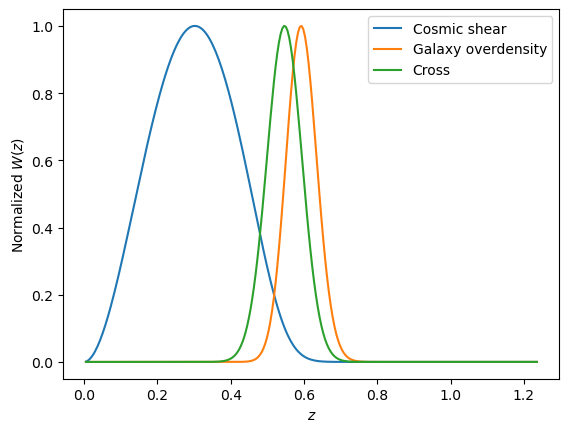

In [19]:
plt.plot(my_grid.z_array[0,:], cs_auto.kernel(my_grid.chi_array) / np.max(cs_auto.kernel(my_grid.chi_array)), label=r'Cosmic shear')
plt.plot(my_grid.z_array[0,:], gc_auto.kernel(my_grid.chi_array) / np.max(gc_auto.kernel(my_grid.chi_array)), label=r'Galaxy overdensity')
plt.plot(my_grid.z_array[0,:], ggl.kernel(my_grid.chi_array) / np.max(ggl.kernel(my_grid.chi_array)), label=r'Cross')

plt.xlabel(r'$z$')
plt.ylabel(r'Normalized $W(z)$')
plt.legend()

To compute the crucial quantity, $C_{\ell}^{\Delta x \Delta y}(\chi)$ (where $x$ and $y$ can be $\phi$ or $g$) we just call

In [20]:
gc_auto.get_Cldp1dp2()

`gc_auto` now has an attribute `gc_auto.Cl_deltap_of_chi1_chi2` that will get used when evaluating the biases. We can already inspect it:

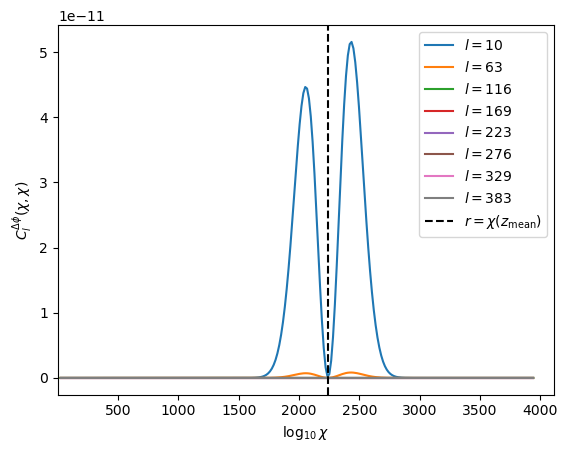

In [21]:
gc_auto.plot_Cl_DeltaP_of_chi()

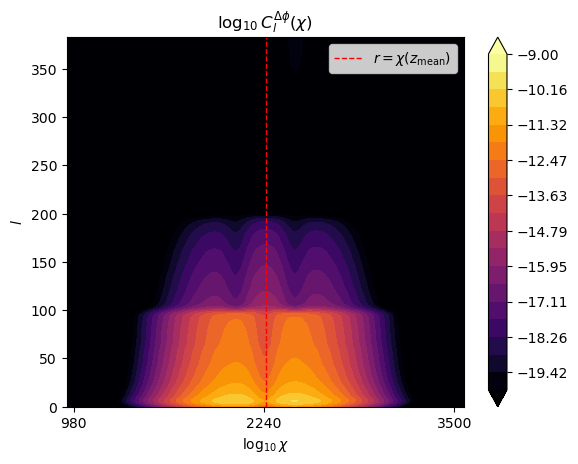

In [22]:
gc_auto.plot_Cl_DeltaP_of_chi_2D()

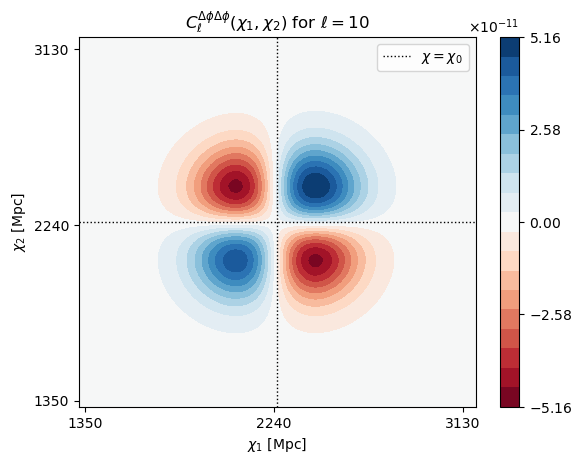

In [23]:
l = 10

gc_auto.plot_Cl_DeltaP_vs_chi_chiprime_2D(l)

# Calculating old and new contributions

More importantly, we're now in a position to calculate all contributions to angular clustering. As an example, consider the galaxy clustering power spectrum.

In [ ]:
gc_auto.get_contributions()

# This is quite fast, but if speed is key, there is an option to parallelize the integrals using multiprocessing.
# Just set get_contributions(num_processes=X) where X is the integer number of processes you want to run in parallel (default is 1).

Note that it is easy for the user to invoke their favorite power spectrum by modifying the the function `spectrum.get_3D_spectrum()`.

This has a mode-coupling bias:

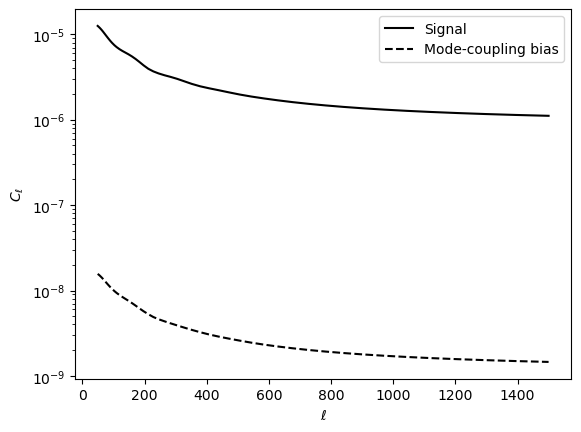

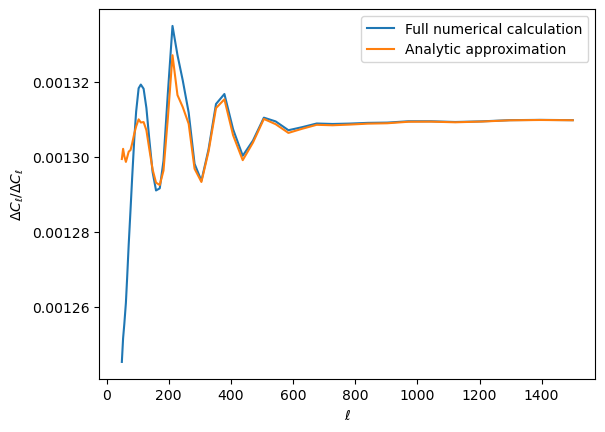

In [25]:
plt.semilogy(gc_auto.ells, gc_auto.unbiased_cls, color='k', label=r'Signal')
plt.semilogy(gc_auto.ells, gc_auto.conv_bias, ls='--', color='k', label=r'Mode-coupling bias')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()

plt.plot(gc_auto.ells, gc_auto.conv_bias/gc_auto.unbiased_cls, label=r'Full numerical calculation')
plt.plot(gc_auto.ells, gc_auto.analytic_mcbias_via_variance/gc_auto.unbiased_cls, label=r'Analytic approximation')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / \Delta C_\ell$')
plt.show()

The second plot shows that the very simple analytic expression we developed in the paper is an excellent approximation!

We can also calculate the additive bias, which is generally much smaller:

Text(0, 0.5, '$C_\\ell$')

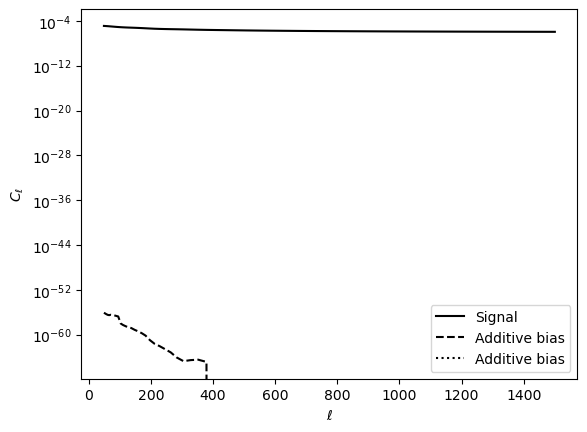

In [28]:
plt.semilogy(gc_auto.ells, gc_auto.unbiased_cls, color='k', label=r'Signal')
plt.semilogy(gc_auto.ells, gc_auto.additive_bias, ls='--', color='k', label=r'Additive bias')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

Finally, note that we can save the object we've computed to file and retrieve it later:

In [66]:
# Save to file
gc_auto.save_properties(output_filename='dict_with_properties')

# Load from file
loaded_object = spectrum.Spec(load=True, filename='dict_with_properties')

# Epilogue: Multi-modal distributions

As a final note, it is also possible to generate a template of variations in the fraction of objects that are in some secondary mode of a multi-modal distribution.


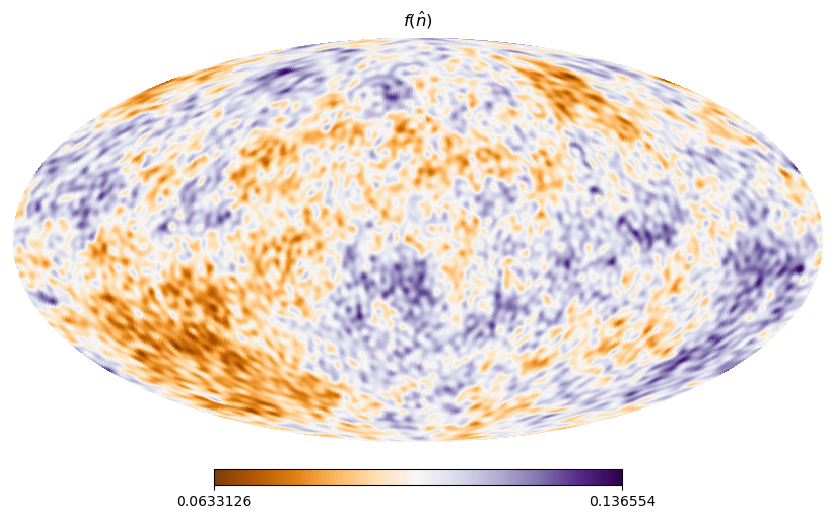

In [29]:
mean_offset = 0.1 # The mean fraction of objects in the secondary mode of the distribution
sigma_of_f_shift = 0.01 # Scale of variations about this mean offset

f_template = templates.MockTemplate(sigma_of_f_shift, nside, -2, 100, mean_offset=mean_offset)
f_template.show(title=r'$f(\hat{n})$')

Studying interlopers ONLY and ignoring any other anisotropy


Text(0, 0.5, '$\\bar{\\phi}(\\chi)$')

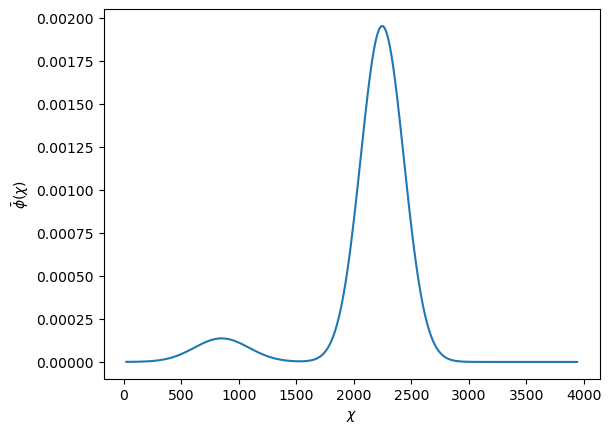

In [33]:
bulk_z_mean = 0.59 # Central redshift of the interloper distribution
bulk_sigma = 0.06 # Width of the interloper distribution (it is assumed to be Gaussian, like the bulk component)

interloper_z_mean = 0.2 # Central redshift of the interloper distribution
interloper_sigma = 0.06 # Width of the interloper distribution (it is assumed to be Gaussian, like the bulk component)


gal_delta_w_interloper = fields.GalDelta(my_grid, bulk_sigma, bulk_z_mean, bvec, template_interloper_frac=f_template,
                                         interloper_sigma=interloper_sigma, interloper_z_mean=interloper_z_mean)

plt.plot(gal_delta_w_interloper.grid.chi_array, gal_delta_w_interloper.p_fid_array)
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\bar{\phi}(\chi)$')

In [ ]:
gg_with_interloper = spectrum.Spec(gal_delta_w_interloper, get_cls=True, save=False)

As before, we can look at the associated mode-coupling bias

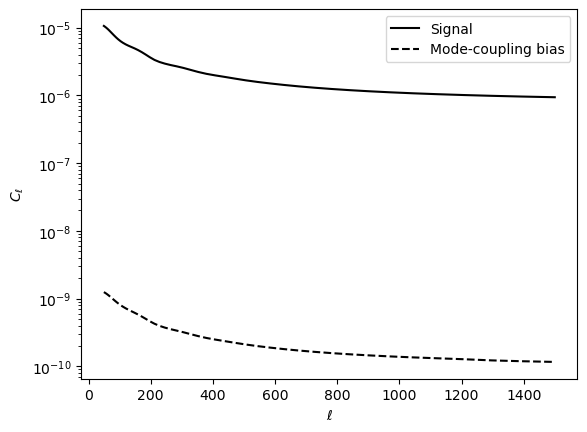

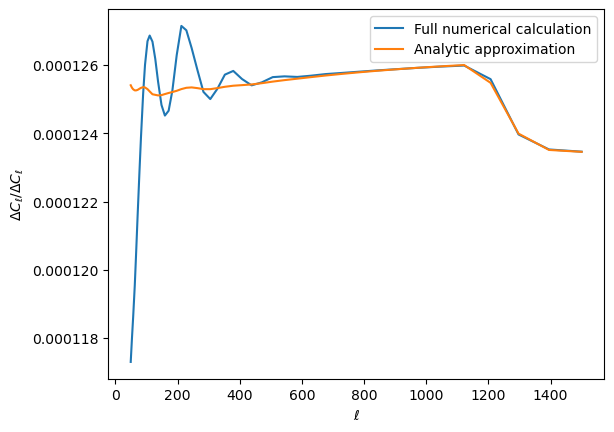

In [36]:
plt.semilogy(gg_with_interloper.ells, gg_with_interloper.unbiased_cls, color='k', label=r'Signal')
plt.semilogy(gg_with_interloper.ells, gg_with_interloper.conv_bias, ls='--', color='k', label=r'Mode-coupling bias')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()

plt.plot(gg_with_interloper.ells, gg_with_interloper.conv_bias/gg_with_interloper.unbiased_cls, label=r'Full numerical calculation')
plt.plot(gg_with_interloper.ells, gg_with_interloper.analytic_mcbias_via_variance/gg_with_interloper.unbiased_cls, label=r'Analytic approximation')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / \Delta C_\ell$')
plt.show()

The step at high $\ell$ in the second plot is an example of something that could go wrong. Because of the $k\sim \ell/\chi$ mapping in Limber, the bump at low $\chi$ probes $k>1$ modes when $\ell$ is order $\chi$. But our galaxy power spectrum is not defined at such high $k$! Be careful with this sort of thing.

And also the additive bias:

Text(0, 0.5, '$C_\\ell$')

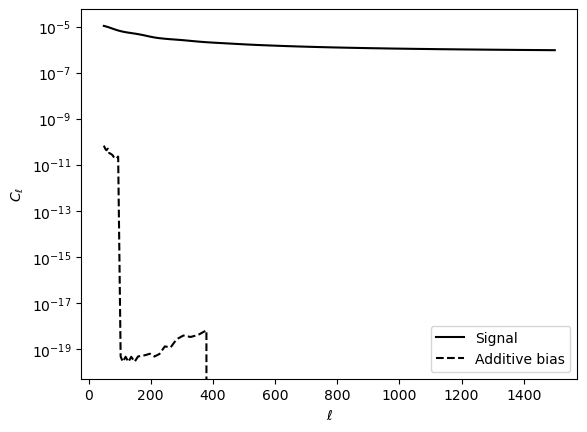

In [37]:
plt.semilogy(gg_with_interloper.ells, gg_with_interloper.unbiased_cls, color='k', label=r'Signal')
plt.semilogy(gg_with_interloper.ells, gg_with_interloper.additive_bias, ls='--', color='k', label=r'Additive bias')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')